# K-Nearest Neighbors

Principle : To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset—its “nearest neighbors.”
Simplest version : take THE closest neighbor (*k=1*)
Advanced version : take the K-nearest neighbors, using a voting system where the majority wins (*k=K*)
Let's start with *k=1* and see how it goes :

### Set up

First import all necessary packages in order not to worry about them when testing new parameters/algorithms:

In [17]:
%load_ext autoreload
%autoreload
from KNeighbors import display_plot, sober_results
from utils import thomas_parser, perf

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First test

Before going further on with the first algorithm, let's retrieve the ground truth from a CSV file generated on the 13th of January 2020 at 2:25 PM. This ground truth gathers results from a thousand malwares collected on the 25th of June 2019.
The data are then splitted between the inputs and outputs as follow :

In [62]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

Let's now create the training and test sets. Since the dataset is quite small,the *80/20* rule is applied for the size of the sets. The *random_state* variable is a seed used to add randomness in the set. Since the purpose of the experiment is to compare results, deterministic values should be favored at first. The value is then set to 0.

In [63]:
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

Normalizing in scikit-learn refers to rescaling each observation (row) to have a length of 1 (called a unit norm in linear algebra).

This preprocessing can be useful for sparse datasets (lots of zeros) with attributes of varying scales when using algorithms that use distance measures such as K-Nearest Neighbors.

Let's normalize our sets then.

In [64]:
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [65]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.77


This model is 77% accurate, which makes sense knowing that the 1000 samples dataset contains a majority of "not packed" malwares.
Let's try with a few other values :

In [66]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.79


In [67]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.83


In [68]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.82


It's interesting to notice that increasing the number of neighbors doesn't always give better results, as the performance with *k=9* is better than *k=3* but worst than *k=6*. This can be more easily visualized with the graph here below.

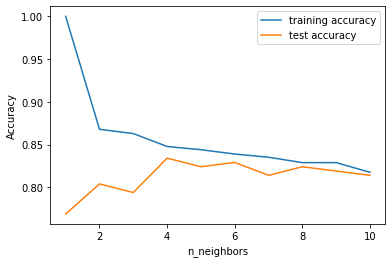

In [69]:
training_accuracy = [] 
test_accuracy = []
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

By looking at the figure, we can see that the best result obtained for the test set corresponds to a  value of *k=4*.
Before that, the model is probably overfitting.
Note that the overall accuracy is not really good. This can be explained because the K-NN algorithm does not perform well on datasets with a lot of features (and this dataset contains more than 100) and sparse datasets, which is also a caracteristic of the dataset used. Trying to preprocess the data might help to increase performance, although this algorithm is known to be really easy to understand and a good way to start experiment while being quite slow with many features.

### Further tests

In order to offer more diversity of tests, the code used before to generate the graph as been put into a Python file in order to be reused easily, namely the *display_plot* function. This method takes a csv (containing the ground truth), a test factor and a number of neighbors as parameters.
We also implemented another version that will only display the results without the plots for more convenience, called *sober_results*.

#### Parameters of the algorithm

In this section, we only change the values of the parameters related to the algorithm itself. Therefore, we stick to the same CSV file when running our tests, containing more samples than the one used in the first test (nearly 8000 lines).

##### Number of neighbors

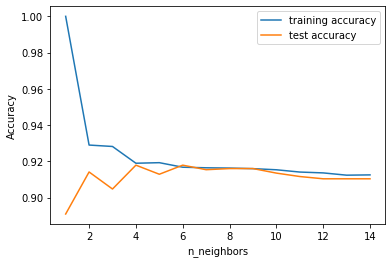

In [70]:
display_plot('../dumps/2020.02.10-12.14.csv',0.20,15)

Once again, we can see that the best results are provided when setting the number of neighbors to 6. Case where n=1 is an overfitting.

#### Minkowsi metric

This is the power parameter for the Minkowski metric. When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2. For arbitrary p, minkowski distance (l_p) is used.

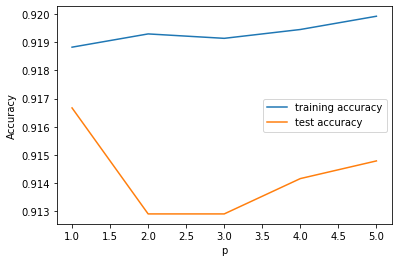

In [73]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

training_accuracy = [] 
test_accuracy = []
neighbors_settings = range(1, 6)
for p in neighbors_settings:
    clf = KNeighborsClassifier(p=p) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("p")
plt.legend()

Default value is p=2 which gives a worse score than manhattan distance (p=1), we should therefore keep l1 for further tests.

##### Test factor

In [74]:
for i in range(10,100,10):
    i=i/100
    print("Test size of %s :"% i)
    sober_results('../dumps/2020.02.10-12.14.csv',i,6)

Test size of 0.1 :
Training set accuracy: 0.92
Test set accuracy: 0.93
Test size of 0.2 :
Training set accuracy: 0.92
Test set accuracy: 0.92
Test size of 0.3 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.4 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.5 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.6 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.7 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.8 :
Training set accuracy: 0.91
Test set accuracy: 0.90
Test size of 0.9 :
Training set accuracy: 0.91
Test set accuracy: 0.90


### Best match

In [6]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [17]:
parameters = {'n_neighbors': np.arange(1,11), 'p':[1,2,3,4,5]}
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

KeyboardInterrupt: 

In [ ]:
parameters = {'n_neighbors': np.arange(1,11), 'p':[1,2,3,4,5]}
clf = RandomizedSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

In [7]:
clf = KNeighborsClassifier(n_neighbors=6,p=1)
clf.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(clf.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(clf.score(data_test, target_test)))

Accuracy on training set: 0.917
Accuracy on test set: 0.918


### Comparison between different kind of datasets

In [18]:
perf('../dumps/control_8000_false_3.csv','neigh')

Accuracy on training set: 0.979
Accuracy on test set: 0.977


#### Different thresholds

In [19]:
perf('../dumps/default_1.csv','neigh')

Accuracy on training set: 0.951
Accuracy on test set: 0.940


In [20]:
perf('../dumps/default_2.csv','neigh')

Accuracy on training set: 0.969
Accuracy on test set: 0.961


In [21]:
perf('../dumps/default_4.csv','neigh')

Accuracy on training set: 0.984
Accuracy on test set: 0.977


In [22]:
perf('../dumps/default_5.csv','neigh')

Accuracy on training set: 0.984
Accuracy on test set: 0.977


#### Errors considered as positive result from detector

In [11]:
perf('../dumps/error_as_packed.csv','neigh')

Accuracy on training set: 0.969
Accuracy on test set: 0.962


#### Check influence of each detector

In [23]:
perf('../dumps/not_die.csv','neigh')

Accuracy on training set: 0.981
Accuracy on test set: 0.977


In [24]:
perf('../dumps/not_cisco.csv','neigh')

Accuracy on training set: 0.982
Accuracy on test set: 0.977


In [25]:
perf('../dumps/not_manalyze.csv','neigh')

Accuracy on training set: 0.982
Accuracy on test set: 0.976


In [26]:
perf('../dumps/not_peid.csv','neigh')

Accuracy on training set: 0.983
Accuracy on test set: 0.977


In [27]:
perf('../dumps/not_peframe.csv','neigh')

Accuracy on training set: 0.984
Accuracy on test set: 0.978


### Test with Thomas datasets

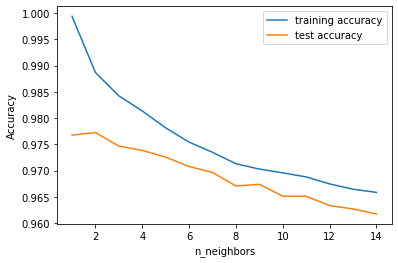

In [75]:
parsed_csv = thomas_parser("../dumps/2019-08.Merged")
gt = pd.read_csv(parsed_csv)
display_plot(parsed_csv,0.20,15)

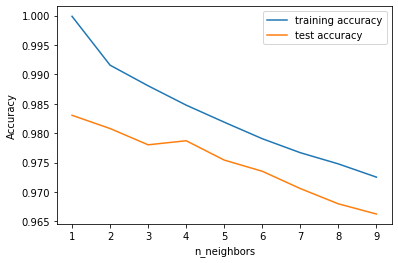

In [76]:
parsed_csv = thomas_parser("../dumps/2019-09.Merged")
gt = pd.read_csv(parsed_csv)
display_plot(parsed_csv,0.20,10)

### PCA

Let's prepare the data for PCA. PCA is effected by scale so we need to scale the features in the data before applying PCA. We can transform the data onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. StandardScaler helps standardize the dataset’s features.
Notice the code below has .95 for the number of components parameter. It means that scikit-learn choose the minimum number of principal components such that 95% of the variance is retained.

In [5]:
gt = pd.read_csv('../dumps/2020.03.11-17.39.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = StandardScaler()
scaler.fit(data_train)
data_train_raw = scaler.transform(data_train)
data_test_raw = scaler.transform(data_test)
cell_text = []
for i in [1,0.99,0.95,0.90,0.85]:
    row = []
    row.append(i)
    start = time.time()
    pca = PCA(i) if i != 1 else PCA()
    pca.fit(data_train_raw)
    data_train = pca.transform(data_train_raw)
    data_test = pca.transform(data_test_raw)
    clf = KNeighborsClassifier(n_neighbors=6,p=2)
    clf.fit(data_train, target_train)
    end = time.time()
    row.append(clf.score(data_train, target_train))
    row.append(clf.score(data_test, target_test))
    row.append(pca.n_components_)
    row.append(end-start)
    cell_text.append(row)
print(tabulate(cell_text, headers = ['Variance','Training acc','Test acc','Components','Time (s)']))

  Variance    Training acc    Test acc    Components    Time (s)
----------  --------------  ----------  ------------  ----------
      1           0.984867    0.979939           119    0.208044
      0.99        0.984867    0.977899            98    0.172354
      0.95        0.984186    0.977219            77    0.160459
      0.9         0.984526    0.978579            60    0.135454
      0.85        0.984696    0.978239            47    0.139791


It's interesting to notice that we can nearly keep the same accuracies while gathering our features from a set of 119 to 47 and clearly improves the timing. Here we're using quite a small dataset (14k), but it makes no doubt that saved time is significant with even more samples.

Let's just test without standardization and with normalization in order to see how performances are impacted.

In [6]:
gt = pd.read_csv('../dumps/2020.03.11-17.39.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

pca = PCA(0.95)

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

pca.fit(data_train)
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)
clf = KNeighborsClassifier(n_neighbors=6,p=2)
clf.fit(data_train, target_train)
print("Training set accuracy: {:.2f}".format(clf.score(data_train, target_train)))
print("Test set accuracy: {:.2f}".format(clf.score(data_test, target_test)))

Training set accuracy: 0.96
Test set accuracy: 0.96


In [7]:
gt = pd.read_csv('../dumps/2020.03.11-17.39.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

pca = PCA(0.95)

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

pca.fit(data_train)
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)
clf = KNeighborsClassifier(n_neighbors=6,p=2)
clf.fit(data_train, target_train)
print("Training set accuracy: {:.2f}".format(clf.score(data_train, target_train)))
print("Test set accuracy: {:.2f}".format(clf.score(data_test, target_test)))

Training set accuracy: 0.97
Test set accuracy: 0.96


Performances are better when we apply Normalization.